<a href="https://colab.research.google.com/github/AndrewRomitti/HippocampusSegmentation/blob/main/Notebook_2_(2D_3D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3D Volumetric UNET Model for Hippocampus Segmentation

In [ ]:
print("Starting Notebook")

Starting Notebook


In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
input_file = files.upload()

Saving kaggle (7).json to kaggle (7).json


In [ ]:
!pip install -q kaggle > /dev/null 2>&1

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/hippocampus-segmentation-in-mri-images

 98% 793M/806M [00:09<00:00, 101MB/s]
100% 806M/806M [00:09<00:00, 85.1MB/s]


In [ ]:
!unzip /content/hippocampus-segmentation-in-mri-images.zip > /dev/null 2>$1

In [ ]:
import nibabel as nb

def prepare_img(image):
  img_data = image.get_fdata()
  img_data_np = np.array(img_data)
  return img_data_np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler=MinMaxScaler()

In [ ]:
img = nb.load("/content/Train/HFH_001.img").get_fdata()
img=scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape) #Line of code taken from https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/232_brats2020_get_data_ready.py

In [ ]:
blank_img = np.zeros((256,10,256,1))

new_img = np.concatenate((blank_img, img),axis=1)
new_img.shape

(256, 128, 256, 1)

In [ ]:
mask = prepare_img(nb.load("/content/Train/Labels/HFH_001_Hipp_Labels.img"))[78:190,0:112,78:190,:]

In [ ]:
mask.shape

(112, 112, 112, 1)

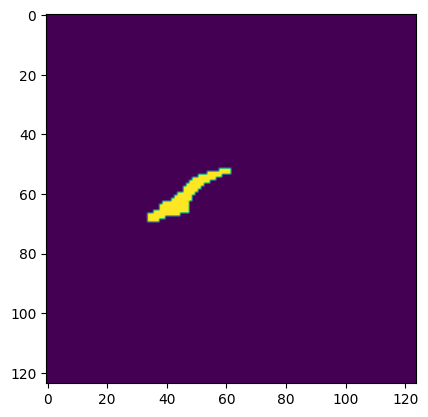

In [ ]:
plt.imshow(mask[90,:,:,:])

In [ ]:
np.unique(mask)

array([0., 1., 2.])

In [ ]:
from tensorflow.keras.utils import to_categorical
mask = to_categorical(mask,3)

In [ ]:
mask.shape

(124, 124, 124, 3)

In [ ]:
#CREDIT FOR THE IDEA TO USE SCALER,CROPPING, AND SAVE IMAGES AS .NPY: https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/232_brats2020_get_data_ready.py
#CREDIT FOR DATAGEN, MY CODE IS A MODIFIED VERSION OF THIS: https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/233_custom_datagen.py

import tqdm
import nibabel as nb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import numpy as np

def create_dataset(TRAIN_PATH="/content/Train", TRAIN_LABEL_PATH="/content/Train/Labels", DEST_IMG="/content/gdrive/MyDrive/HippoDs/Dataset/Images/Train", DEST_LABEL='/content/gdrive/MyDrive/HippoDs/Dataset/Labels/Train'):

  scaler = MinMaxScaler()
  for file in tqdm.tqdm(sorted(os.listdir(TRAIN_PATH))[:30]): #up to 31 only because image sizes change
    if file=="Labels" or os.path.splitext(file)[1]==".hdr":
      continue
    else:
      img = nb.load(os.path.join(TRAIN_PATH,file))
      img = img.get_fdata()
      img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

      blank_10 = np.zeros((256,20,256,1))
      img = np.concatenate((blank_10, img),axis=1)

      img = img[70:198,0:128,70:198,:] #making sizes 128x128x128

      mask = nb.load(os.path.join(TRAIN_LABEL_PATH,os.path.splitext(file)[0]+"_Hipp_Labels.img"))
      mask = mask.get_fdata()

      blank_masks = np.zeros((256,20,256,1))
      mask = np.concatenate((blank_masks, mask),axis=1)
      mask = mask[70:198,0:128,70:198,:]
      mask = to_categorical(mask,3)

      np.save(os.path.join(DEST_IMG, str(file)+".npy"),img)
      np.save(os.path.join(DEST_LABEL, str(file)+"_L_.npy"),mask)

In [ ]:
create_dataset()

100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_reals_path = "/content/gdrive/MyDrive/HippoDs/Dataset/Images/Train"
dataset_labels_path = "/content/gdrive/MyDrive/HippoDs/Dataset/Labels/Train"

dataset_reals_test = "/content/gdrive/MyDrive/HippoDs/Dataset/Images/Test"
dataset_labels_test ="/content/gdrive/MyDrive/HippoDs/Dataset/Labels/Test"

In [ ]:
#import tensorflow as tf

#if tf.config.list_physical_devices('GPU'):
#  print('GPU available')
#else:
#  print('No GPU available')

No GPU available


In [ ]:
import os
import numpy as np

def data_loader(real_path=dataset_reals_path, mask_path=dataset_labels_path, bs=3):

  while True:
    c_b_idx=0
    while c_b_idx+bs <= len(os.listdir(real_path)):
      imgs=[]
      msks=[]
      for file in sorted(os.listdir(real_path)[c_b_idx:c_b_idx+bs]):
        X = np.load(os.path.join(real_path, file))
        X = np.repeat(X, 3, axis=3)
        Y = np.load(os.path.join(mask_path,os.path.splitext(file)[0]+"_L_.npy"))
        imgs.append(X)
        msks.append(Y)

      imgs = np.array(imgs)
      msks = np.array(msks)
      c_b_idx+=bs
      yield(tf.convert_to_tensor(imgs, np.float32), tf.convert_to_tensor(msks, np.float32))



    print("Completed")

def test_data_loader(real_path=dataset_reals_test, mask_path=dataset_labels_test, bs=3):
    while True:
      c_b_idx=0
      while c_b_idx+bs <= len(os.listdir(real_path)):
        imgs=[]
        msks=[]
        for file in sorted(os.listdir(real_path)[c_b_idx:c_b_idx+bs]):
          X = np.load(os.path.join(real_path, file))
          X = np.repeat(X, 3, axis=3)
          Y = np.load(os.path.join(mask_path,os.path.splitext(file)[0]+"_L_.npy"))
          imgs.append(X)
          msks.append(Y)

        imgs = np.array(imgs)
        msks = np.array(msks)
        c_b_idx+=bs
        yield(tf.convert_to_tensor(imgs, np.float32), tf.convert_to_tensor(msks, np.float32))




In [ ]:
len(sorted(os.listdir(dataset_reals_test)))

3

In [ ]:
img.shape

In [ ]:
!pip install -U -q segmentation-models-3D

In [ ]:
import os
from tensorflow import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
import tensorflow as tf
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
dataset = tf.data.Dataset.from_generator(data_loader,
                                         output_types=(tf.float32, tf.float32))

dataset_test = tf.data.Dataset.from_generator(test_data_loader,
                                         output_types=(tf.float32, tf.float32))

img, mask = next(iter(dataset))

In [ ]:
img, mask = next(iter(dataset_test))

In [ ]:
img.shape

TensorShape([3, 128, 128, 128, 3])

In [ ]:
model = sm.Unet("resnet34",input_shape=(128,128,128,3), encoder_weights=None,classes=3)
loss = sm.losses.DiceLoss()
metric = sm.metrics.FScore()
model.compile('Adam', loss=loss, metrics=[metric])

In [ ]:
model.fit(
    dataset,
    batch_size=3,
    validation_data=dataset_test,
    steps_per_epoch=4,
    validation_steps=1,
    validation_batch_size=3,
    epochs=160
)

Epoch 1/160
4/4 [==============================] - 553s 130s/step - loss: 0.7641 - f1-score: 0.2359 - val_loss: 1.0000 - val_f1-score: 2.0596e-05
Epoch 2/160
Completed
4/4 [==============================] - 503s 130s/step - loss: 0.7218 - f1-score: 0.2782 - val_loss: 0.9950 - val_f1-score: 0.0050
Epoch 3/160
Completed
4/4 [==============================] - 501s 130s/step - loss: 0.7010 - f1-score: 0.2990 - val_loss: 0.9945 - val_f1-score: 0.0055
Epoch 4/160
Completed
4/4 [==============================] - 458s 114s/step - loss: 0.6812 - f1-score: 0.3188 - val_loss: 0.9819 - val_f1-score: 0.0181
Epoch 5/160
Completed
4/4 [==============================] - 500s 122s/step - loss: 0.6721 - f1-score: 0.3279 - val_loss: 0.7207 - val_f1-score: 0.2793
Epoch 6/160
Completed
4/4 [==============================] - 498s 129s/step - loss: 0.6682 - f1-score: 0.3318 - val_loss: 0.6691 - val_f1-score: 0.3309
Epoch 7/160
Completed
4/4 [==============================] - 503s 128s/step - loss: 0.6660 - f

In [ ]:
#CREDIT FOR 3D UNET MODEL: https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/simple_3d_unet.py

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

kernel_initializer =  'he_uniform'

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def unet(input_size=(128,128,128,3),n_classes=3):
    inputs = Input(input_size)

    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(n_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

In [ ]:
model = unet((128,128,128,3),3)
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=dice_coef_loss,
              metrics=[dice_coef,
                       'binary_accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1312      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout[0][0]']             
                                                                                              

In [ ]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
loss_history = model.fit(dataset,
                  epochs = 50,
                  validation_data =(dataset_test))

Epoch 1/50
      3/Unknown - 6s 2s/step - loss: 0.0027 - dice_coef: 0.9973 - binary_accuracy: 0.9983Completed
      7/Unknown - 13s 2s/step - loss: 0.0027 - dice_coef: 0.9973 - binary_accuracy: 0.9983Completed
     11/Unknown - 20s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983Completed
     15/Unknown - 28s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983Completed
     19/Unknown - 35s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983Completed
     23/Unknown - 43s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983Completed
     27/Unknown - 50s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983Completed
     31/Unknown - 58s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983Completed
     35/Unknown - 65s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983Completed
     39/Unknown - 73s 2s/step - loss: 0.0026 - dice_coef: 0.9974 - binary_accuracy: 0.9983

KeyboardInterrupt: ignored

In [ ]:
print(model.summary())

In [ ]:
test_imgs, test_labels = next(iter(dataset))
predictions = model.predict(test_imgs)

1/1 [==============================] - 0s 260ms/step


In [ ]:
predictions = np.expand_dims(predictions,axis=4)

In [ ]:
predictions = np.argmax(predictions,axis=4)

In [ ]:
predictions.shape

(3, 128, 128, 128)

In [ ]:
np.where(predictions[0][50]==2)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
predictions[0][50].shape

(128, 128)

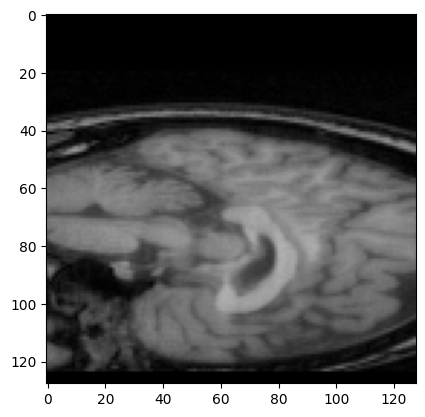

In [ ]:
plt.imshow(test_imgs[0][60])

In [ ]:
for idx, val in np.ndenumerate(predictions[2]):
  if val==1 or val==2:
    print(idx)

(1, 127, 0)
(2, 123, 127)
(7, 126, 127)
(7, 127, 0)
(17, 127, 0)
(19, 126, 127)
(23, 126, 127)
(35, 126, 127)
(51, 126, 127)
(67, 126, 127)
(83, 126, 127)
(99, 126, 127)
(107, 126, 127)
(112, 126, 125)
(120, 126, 125)
(125, 127, 127)
(126, 6, 0)
(126, 52, 0)
(126, 68, 0)
(126, 76, 0)
(126, 84, 0)
(126, 88, 0)
(126, 92, 0)
(126, 100, 0)
(126, 104, 0)
(126, 108, 0)
(126, 116, 0)
(126, 120, 0)
(126, 124, 0)
(126, 127, 2)
(127, 1, 3)
(127, 5, 1)
(127, 6, 127)
(127, 8, 0)
(127, 13, 1)
(127, 14, 127)
(127, 16, 0)
(127, 17, 1)
(127, 21, 1)
(127, 22, 127)
(127, 23, 1)
(127, 24, 0)
(127, 25, 1)
(127, 29, 1)
(127, 30, 127)
(127, 32, 0)
(127, 33, 1)
(127, 37, 1)
(127, 38, 127)
(127, 39, 1)
(127, 40, 0)
(127, 41, 1)
(127, 45, 1)
(127, 46, 127)
(127, 48, 0)
(127, 49, 1)
(127, 53, 1)
(127, 54, 127)
(127, 55, 1)
(127, 56, 0)
(127, 57, 1)
(127, 61, 1)
(127, 63, 1)
(127, 64, 0)
(127, 65, 1)
(127, 69, 1)
(127, 70, 127)
(127, 71, 1)
(127, 72, 0)
(127, 72, 127)
(127, 73, 1)
(127, 77, 1)
(127, 78, 127)
(12

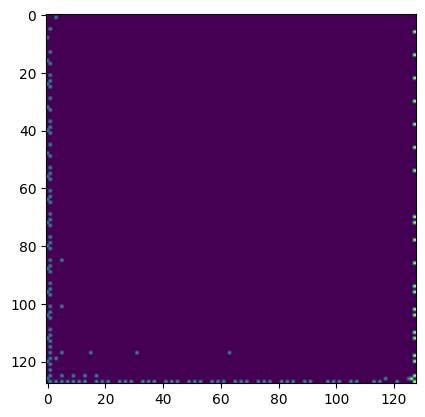

In [ ]:
plt.imshow(predictions[2][127])

TypeError: ignored

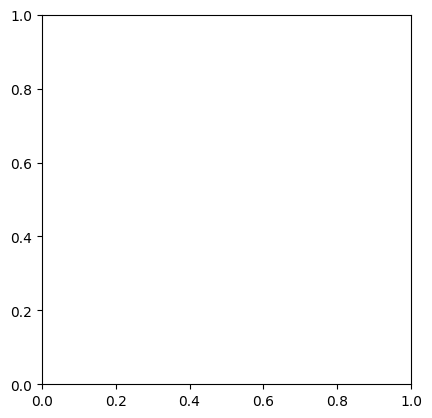

In [ ]:
plt.imshow(predictions[0][17,127,0])

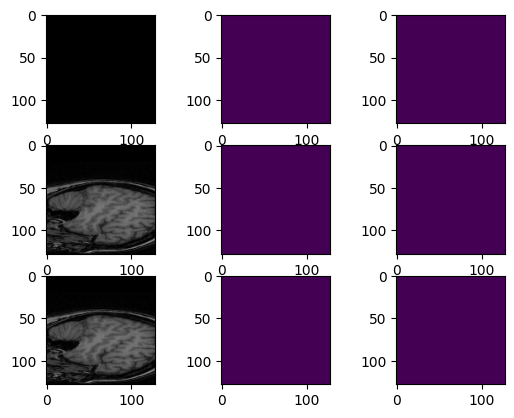

In [ ]:
import matplotlib.pyplot as plt

rand = np.random.randint(0,112)

plt.subplot(3,3,1)
plt.imshow(np.array(test_imgs)[0][:,rand,:,:])

plt.subplot(3,3,2)
plt.imshow(np.array(np.argmax(test_labels,axis=4))[0][rand])

plt.subplot(3,3,3)
plt.imshow(np.array(predictions)[0][rand])

plt.subplot(3,3,4)
plt.imshow(np.array(test_imgs)[0][rand])

plt.subplot(3,3,5)
plt.imshow(np.array(np.argmax(test_labels,axis=4))[0][rand])

plt.subplot(3,3,6)
plt.imshow(np.array(predictions)[0][rand])

plt.subplot(3,3,7)
plt.imshow(np.array(test_imgs)[0][rand])

plt.subplot(3,3,8)
plt.imshow(np.array(np.argmax(test_labels,axis=4))[0][rand])

plt.subplot(3,3,9)
plt.imshow(np.array(predictions)[0][rand])

In [ ]:
from tensorflow.keras.optimizers import Adam
optim = Adam(learning_rate=learning_rate)

loss_to_use = sm.losses.bce_jaccard_loss
model.compile(optimizer=optim, loss=loss_to_use, metrics=[sm.metrics.iou_score, sm.metrics.f1_score])

NameError: ignored

In [ ]:
img, mask = data_gen.__next__()

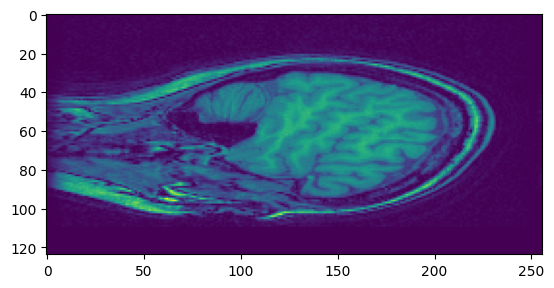

In [ ]:
plt.imshow(prepare_img(nb.load("/content/Train/HFH_001.img"))[72,:,:,:])

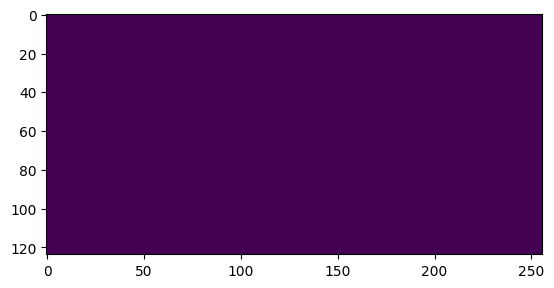

In [ ]:
plt.imshow(prepare_img(nb.load("/content/Train/Labels/HFH_001_Hipp_Labels.img"))[73,:,:,:])

#2D Slice UNET

In [ ]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import nibabel as nb
import tqdm

In [ ]:
import tqdm

def create_train_dataset(TRAIN_PATH="/content/Train", TRAIN_LABEL_PATH="/content/Train/Labels", sizes=256):

  print("Preparing Real Images")

  train_index = sorted(os.listdir(TRAIN_PATH))[:31] if sizes==256 else sorted(os.listdir(TRAIN_PATH))[31:]
  label_index = sorted(os.listdir(TRAIN_LABEL_PATH))[:31] if sizes==256 else sorted(os.listdir(TRAIN_LABEL_PATH))[31:]

  train_image_idx=0
  for file in tqdm.tqdm(train_index):
    if file=="Labels" or os.path.splitext(file)[1]==".hdr":
      continue
    elif file==sorted(os.listdir(TRAIN_PATH))[1]:
      img = nb.load(os.path.join(TRAIN_PATH,file))
      training_set = prepare_img(img)[50:90] #range selected to decrease no-pixel masks
    else:

      img = nb.load(os.path.join(TRAIN_PATH,file))
      if sizes==512 and train_image_idx==0:
        training_set = prepare_img(img)[50:90]

      temp_train_set = prepare_img(img)[50:90]
      if file=="HFH_025.img":
        temp_train_set = np.expand_dims(temp_train_set, axis=3)

      training_set = np.concatenate((training_set, temp_train_set),axis=0)
      train_image_idx+=1

  print("Real Images Initalized. Real Images Shape:",training_set.shape)
  print("Number of Training Images:",training_set.shape[0])

  print("Preparing Labels")

  label_training_idx=0
  for file in tqdm.tqdm(label_index):
    if file=="Labels" or os.path.splitext(file)[1]==".hdr":
      continue
    elif file==sorted(os.listdir(TRAIN_LABEL_PATH))[1]:
      img = nb.load(os.path.join(TRAIN_LABEL_PATH,file))
      training_set_l = prepare_img(img)[50:90]
    else:

      img = nb.load(os.path.join(TRAIN_LABEL_PATH,file))

      if sizes==512 and label_training_idx==0:
        training_set_l = prepare_img(img)[50:90]

      temp_train_set = prepare_img(img)[50:90]
      training_set_l = np.concatenate((training_set_l, temp_train_set),axis=0)
      label_training_idx+=1

  print("\nLabel Images Initalized. Label Images Shape:",training_set_l.shape)
  print("Number of Label Images:",training_set_l.shape[0])

  return training_set, training_set_l

In [ ]:
def create_validation_dataset(VALID_PATH="/content/Test",sizes=256):

  train_index = sorted(os.listdir(VALID_PATH))[:31] if sizes==256 else sorted(os.listdir(VALID_PATH))[31:]
  valid_idx=0

  for file in tqdm.tqdm(train_index):
    if file=="Labels" or os.path.splitext(file)[1]==".hdr":
      continue
    elif file==sorted(os.listdir(VALID_PATH))[1]:
      img = nb.load(os.path.join(VALID_PATH,file))
      training_set = prepare_img(img)
    else:
      img = nb.load(os.path.join(VALID_PATH,file))

      if sizes==512 and valid_idx==0:
        training_set = prepare_img(img)

      temp_train_set = prepare_img(img)
      training_set = np.concatenate((training_set, temp_train_set),axis=0)
      valid_idx+=1

  return training_set

In [ ]:
reals_512, labels_512 = create_train_dataset(sizes=512)
reals_256, labels_256 = create_train_dataset()

Preparing Real Images


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


Real Images Initalized. Real Images Shape: (440, 512, 512, 1)
Number of Training Images: 440
Preparing Labels


100%|██████████| 19/19 [00:04<00:00,  4.40it/s]



Label Images Initalized. Label Images Shape: (440, 512, 512, 1)
Number of Label Images: 440
Preparing Real Images


100%|██████████| 31/31 [00:01<00:00, 17.40it/s]


Real Images Initalized. Real Images Shape: (600, 256, 256, 1)
Number of Training Images: 600
Preparing Labels


100%|██████████| 31/31 [00:01<00:00, 17.15it/s]


Label Images Initalized. Label Images Shape: (600, 256, 256, 1)
Number of Label Images: 600


In [ ]:
valid_ds_512 = create_validation_dataset(sizes=512)
valid_ds_256 = create_validation_dataset()

100%|██████████| 31/31 [00:03<00:00,  9.41it/s]


In [ ]:
from sklearn.model_selection import train_test_split


#X_train_512, X_test_512, y_train_512, y_test_512 = train_test_split(reals_512, labels_512, test_size=0.2, random_state=0, shuffle=True)
X_train_256, X_test_256, y_train_256, y_test_256 = train_test_split(reals_256, labels_256, test_size=0.2, random_state=0, shuffle=True)

In [ ]:
y_test_256.dtype

dtype('float64')

In [ ]:
def resize_images(image, label, slice_idx=0,img_sizes=512):
  img = tf.image.resize(image, (img_sizes,img_sizes))
  lbl = tf.image.resize(label, (img_sizes,img_sizes))
  return tf.cast(img, 'float64'), tf.cast(lbl,'float64')

In [ ]:
BATCH_SIZE = 8
DS_SIZE=1848

#dataset_test_512 = tf.data.Dataset.from_tensor_slices((X_test_512, y_test_512))
#dataset_test_512 = dataset_test_512.batch(BATCH_SIZE)

dataset_test_256 = tf.data.Dataset.from_tensor_slices((X_test_256, y_test_256))
dataset_test_256 = dataset_test_256.batch(BATCH_SIZE)
dataset_test_256 = dataset_test_256.map(lambda x,y: resize_images(x,y,img_sizes=256))

#dataset_train_512 = tf.data.Dataset.from_tensor_slices((X_train_512, y_train_512))
#dataset_train_512 = dataset_train_512.batch(BATCH_SIZE)

dataset_train_256 = tf.data.Dataset.from_tensor_slices((X_train_256, y_train_256))
dataset_train_256 = dataset_train_256.batch(BATCH_SIZE)
dataset_train_256 = dataset_train_256.map(lambda x,y: resize_images(x,y,img_sizes=256))

#dataset_train = dataset_train_256.concatenate(dataset_train_256)

#dataset_test = dataset_test_512.zip(dataset_test_256)

#dataset_train = dataset_train.batch(BATCH_SIZE)
#dataset_test = dataset_test.batch(BATCH_SIZE)

In [ ]:
def normalization(image,label):
  img = tf.cast(image, tf.float32)/255.
  lbl = tf.where(tf.cast(label, tf.float32)/255. > 0, 1.0, 0.0)
  return img, lbl

In [ ]:
dataset_train_256 = dataset_train_256.map(lambda x, y: normalization(x,y))
dataset_test_256 = dataset_test_256.map(lambda x, y: normalization(x,y))

dataset_train_256 = dataset_train_256.shuffle(1800*10)
dataset_train_256 = dataset_train_256.repeat(5)

In [ ]:
dataset_test = dataset_test.map(lambda x, y: normalization(x,y)) #normalization
dataset_train = dataset_train.map(lambda x, y: normalization(x,y)) #normalization

In [ ]:
dataset_test

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 512, 512, 1), dtype=tf.float32, name=None))>

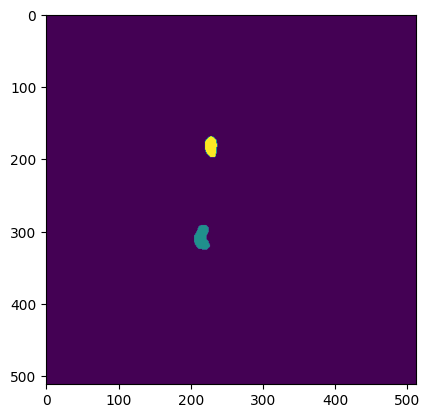

In [ ]:
plt.imshow(y_test_512[70])

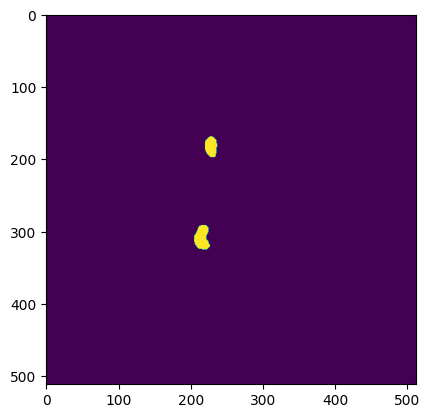

In [ ]:
plt.imshow(tf.where(tf.cast(y_test_512[70], tf.float32)/255. > 0, 1.0, 0.0))

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet((256,256,1))
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=dice_coef_loss,
              metrics=[dice_coef,
                       'binary_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [ ]:
model.fit(X_train, y_train, batch_size=4, epochs=1)

620/620 [==============================] - 66s 77ms/step - loss: -0.9247 - dice_coef: 1.9247 - binary_accuracy: 0.1533


In [ ]:
!pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [ ]:
model = sm.Unet('vgg19', input_shape=(256,256,1), encoder_weights=None, decoder_block_type='transpose')

#model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

loss = sm.losses.DiceLoss()
metric = sm.metrics.FScore()
model.compile('Adam', loss=loss, metrics=[metric])

model.fit(
    dataset_train_256,
    epochs=150,
    validation_data=(dataset_test_256),
)

Epoch 1/150
300/300 [==============================] - 105s 279ms/step - loss: 0.9884 - f1-score: 0.0116 - val_loss: 0.9893 - val_f1-score: 0.0107
Epoch 2/150
300/300 [==============================] - 83s 274ms/step - loss: 0.9846 - f1-score: 0.0154 - val_loss: 0.9999 - val_f1-score: 1.2194e-04
Epoch 3/150
300/300 [==============================] - 83s 275ms/step - loss: 0.9929 - f1-score: 0.0071 - val_loss: 1.0000 - val_f1-score: 1.6184e-05
Epoch 4/150
300/300 [==============================] - 83s 274ms/step - loss: 0.9879 - f1-score: 0.0121 - val_loss: 1.0000 - val_f1-score: 1.3718e-05
Epoch 5/150
300/300 [==============================] - 82s 273ms/step - loss: 0.9977 - f1-score: 0.0023 - val_loss: 0.9999 - val_f1-score: 8.6411e-05
Epoch 6/150
300/300 [==============================] - 82s 273ms/step - loss: 0.9950 - f1-score: 0.0050 - val_loss: 0.9911 - val_f1-score: 0.0089
Epoch 7/150
300/300 [==============================] - 82s 273ms/step - loss: 0.9878 - f1-score: 0.0122 - v

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(X_test)

12/12 [==============================] - 25s 1s/step


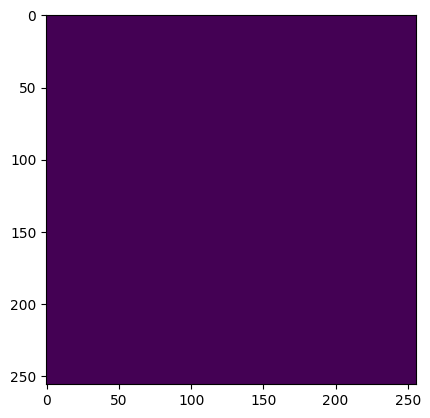

In [ ]:
plt.imshow(y_test[2])

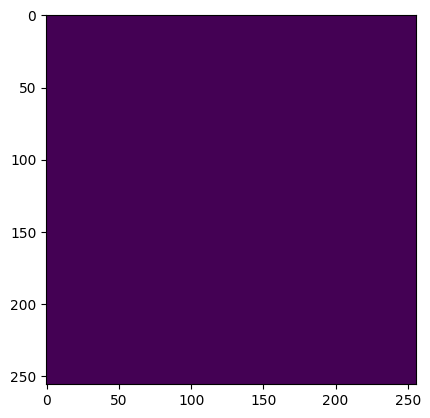

In [ ]:
plt.imshow(X_test[9])

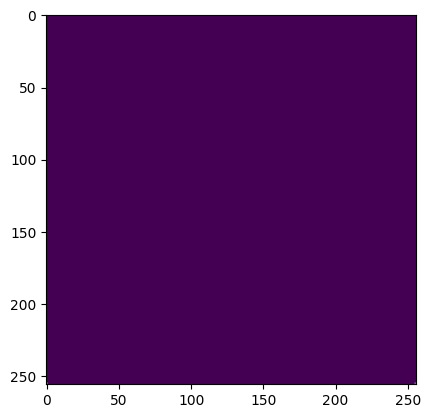

In [ ]:
plt.imshow(preds[2])